In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import shapely as shp
from tqdm import tqdm

import myprofiler as mp
import cleantools as clnt

# Initial Reporting #

In this section, I will do an initial reporting using *pandas-profiling* tool without any processing on the data. These reports will give basic insight in each section of the relational data set.

In [ ]:
# We define files to look at as dictionary
files = {
    "locations": "../data/locations_20200520_143742.xlsx",
    "persons": "../data/persons_20200520_143122.xlsx",
    "personMentions": "../data/person_mentions_20200520_143017.xlsx",
    "personRelationships": "../data/person_relationships_20200520_143219.xlsx",
    "professions": "../data/professions_20200520_143812.xlsx",
    "categories": "../data/profession_categories_20200520_143818.xlsx",
}

# And in the contracts file, there are five sheets to extract
contracts_sheets = [
    "Contracts",
    "Person Mentions",
    "Hosting Conditions",
    "Financial Conditions",
    "Events",
]

In [ ]:
print("Extracting sheets from contracts...")
all_sheets = mp.readFromXlsx(
    "../data/contracts_20200520_142649.xlsx", contracts_sheets
)

print("Extracting Rest of the xlsx documents...")
for name, file in tqdm(files.items()):
    all_sheets[name] = mp.readFromXlsx(file)

print("Reporting each contracts sheet...")
for name, df in tqdm(all_sheets.items()):
    mp.getReport(df, "_".join(name.split()))

Finally, we save the *all_sheets* variable in a pickle, for easy access.

In [ ]:
clnt.savePickle(all_sheets, "../data/pickles/table_of_all.pkl")

# Cleaning the Data #

In [9]:
# Main data frame dictionary
all_sheets = clnt.loadPickle("../data/pickles/all_sheets.pkl")

Here, I will prepare the data for further usage. I first take a look at the *Duration* data in the *Events* sheet. There are three columns representing day, month, and year, which can be merged into one column in day counts.

In [ ]:
# Merging different duration data into one numeric column
events = all_sheets["Events"].copy()
events["Duration - Merged"] = (
    events["Duration - Years"] * 365
    + events["Duration - Months"] * 30
    + events["Duration - Days"]
)
events.loc[events["Start Date"].astype(str).apply(lambda x:len(x.split("-"))) < 3, "Start Date"] = "0000-00-00"
clnt.savePickle(events, "../data/pickles/clean_events.pkl")

Secondly, I explore the ages of apprentices, after cleaning up the string formatted entries.

In [5]:
# Load data frame
person_mentions = all_sheets["Person Mentions"].copy()

# Eliminate non int
person_mentions["Age - Standard Form"] = pd.to_numeric(person_mentions["Age"], errors="coerce")

# Fix typo
person_mentions["Professions - Standard Form"] = person_mentions[
    "Professions - Standard Forms"
].copy()

# Eliminate Transcript form columns, and delete amended columns
person_mentions = clnt.cleanColumns(
    person_mentions, to_go=["Professions - Standard Forms", "Age"], eliminate_list=["Transcript"]
)

# Save the results
clnt.savePickle(person_mentions, "../data/pickles/clean_mentions.pkl")

0         18.0
1          NaN
2         10.0
3          NaN
4          NaN
          ... 
156128     NaN
156129     NaN
156130     NaN
156131     NaN
156132     NaN
Name: Age, Length: 156133, dtype: float64

Now we restructure the professions section of the data, for easier access in future.

In [ ]:
# Load dataframes
professions = all_sheets["professions"].copy()[["Standard Form", "Category ID"]]
categories = all_sheets["categories"].copy()[["ID", "Label", "Sectors", "Parent Category ID"]]
categories2 = categories.copy()[["ID", "Sectors", "Label"]]

# Fix self referencing with merging with itself and renaming
categories_merged = categories.merge(categories2, left_on="Parent Category ID", right_on="ID", how="left")
categories_merged["Sectors"] = categories_merged["Sectors_x"].fillna(categories_merged["Sectors_y"])
categories_merged["Parent Label"] = categories_merged["Label_y"].fillna(categories_merged["Label_x"])
categories_merged = categories_merged[["ID_x", "Label_x", "Sectors", "Parent Label"]].copy()
categories_merged.columns = ["ID", "Label", "Sector", "Parent Label"]

# Reshape sectors to be numeric dummy variables
categories_merged["Sector"] = categories_merged["Sector"].apply(lambda x:x.split(","))
categories = categories_merged.copy()[["ID", "Label", "Parent Label"]]
categories_merged = categories_merged.explode("Sector")
categories_sections = clnt.hotEncode(categories_merged,
                                     categories_merged.Sector,
                                     group="Label",
                                     operation="max")[["Label","S/T","T","P","S"]]
categories = categories.merge(categories_sections, on="Label")

# Add categories to the main frame, and trim extras
professions = professions.merge(categories, left_on="Category ID",
                                right_on="ID", how="left")[["Standard Form",
                                                            "Category ID", "Label",
                                                            "Parent Label", "S/T",
                                                            "T", "P", "S"]]

clnt.savePickle(professions, "../data/pickles/clean_professions_trimmed.pkl")

Now we convert the date time data into pandas form. The pandas date time data type has a minimum limit, which makes half of our data point not applicable, so we will map each date to 200 years later in the data set.

In [4]:
def shiftDate(x):
    """Takes in a date, converts it to 200 years later"""
    alst = str(x).split("-")
    if len(alst) == 3:
        alst[0] = str(int(alst[0])+200)
    return "-".join(alst)
    

In [10]:
# Load dataFrame, and convert values
contracts = all_sheets["Contracts"].copy().set_index("Contract ID")
contracts["Date"] = pd.to_datetime(contracts["Date"].apply(shiftDate), errors="coerce")

# Save the results
clnt.savePickle(contracts, "../data/pickles/clean_contracts.pkl")

Now I convert relations to only apprentice side, to standardize the direction of them.

In [11]:
def changePers(x, g):
    """Takes in a relation from person 1 to person 2 and the gender of person 1. Returns the relation
    in perspective of person 2"""
    x_temp = x[5:]
    if isinstance(x, float) or isinstance(g, float):
        return x
    for key in to_from.keys():
        if key in x_temp and to_from[key].lower() in fixables:
            x_temp = x_temp.replace(key, gender_fix[to_from[key]+g])
        elif key in x_temp:
            x_temp = x_temp.replace(key, to_from[key])
            break
    return x[:5]+x_temp

In [12]:
# Set Constants
to_from = {
    "Father": "Child",
    "father": "child",
    "Aunt": "NepSmt",
    "Uncle": "NepSmt",
    "Mother": "Child",
    "mother": "child",
    "Daughter": "Parent",
    "Son": "Parent",
    "daughter": "parent",
    "son": "parent",
    "Widow": "Widower",
    "Widower": "Widow",
    "AdopterOf": "AdoptedBy",
    "Husband": "Wife",
    "Brother": "Sibling",
    "brother": "sibling",
    "Daughter": "Sibling",
    "daughter": "sibling"
}

gender_fix = {
    "Childgrz:Male": "Son",
    "childgrz:Male": "son",
    "Childgrz:Female": "Daughter",
    "childgrz:Female": "daughter",
    "NepSmtgrz:Male": "Nephew",
    "NepSmtgrz:Female": "Niece",
    "Parentgrz:Male": "Father",
    "parentgrz:Male": "father",
    "Parentgrz:Female": "Mother",
    "parentgrz:Female": "mother",
    "Siblinggrz:Male": "Brother",
    "siblinggrz:Male": "brother",
    "Siblinggrz:Female": "Sister",
    "siblinggrz:Female": "sister",
}

fixables = ["child", "nepsmt", "parent", "sibling"]

In [13]:
# Load frames
person_relations = all_sheets["personRelationships"]
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")

# Get relations from apprentice to people
person_relations_1 = person_relations.merge(mentions, left_on="Person 1 ID", right_on="Person ID", how="left")
person_relations_1 = person_relations_1[person_relations_1["Tag"] == "grz:Apprentice"][["Person 2 ID", "Relationship Type"]]

# Get relations from people to apprentice
person_relations_2 = person_relations.merge(mentions[["Person ID", "Tag"]], left_on="Person 2 ID", right_on="Person ID", how="left")
person_relations_2 = person_relations_2.merge(mentions[["Person ID", "Gender"]], left_on="Person 1 ID", right_on="Person ID", how="left")
person_relations_2 = person_relations_2[person_relations_2["Tag"] == "grz:Apprentice"][["Person 1 ID", "Relationship Type", "Gender"]]

# Convert them to "from apprentice" form
person_relations_2["Relationship Type"] = person_relations_2.apply(lambda x: changePers(x['Relationship Type'], x['Gender']), axis=1)

# Merge both lists
person_relations_m = person_relations_1.merge(person_relations_2, left_on="Person 2 ID", right_on="Person 1 ID", how="outer")
person_relations_m["Relationship Type_x"] = person_relations_m["Relationship Type_x"].fillna(person_relations_m["Relationship Type_y"])
person_relations_m["Person 1 ID"] = person_relations_m["Person 1 ID"].fillna(person_relations_m["Person 2 ID"])

# Fix formatting issues
person_relations_m = person_relations_m[["Person 1 ID", "Relationship Type_x"]]
person_relations_m.columns = ["Person ID", "Relationship From Apprentice"]
person_relations_m = person_relations_m.drop_duplicates("Person ID")

# Save for further usage
clnt.savePickle(person_relations_m, "../data/pickles/directed_person_relations.pkl")

# Creating a Table with Many Useful Columns #

In order to store as much as possible, I will make one main table with contracts as index, and another which can be grouped to contracts, to hold people in the contracts.

## The Main Table ##

In [ ]:
# Load dataframes
# Main data frame dictionary
all_sheets = clnt.loadPickle("../data/pickles/all_sheets.pkl")

contracts = clnt.loadPickle(
    "../data/pickles/clean_contracts.pkl"
)[["Date"]]

events = clnt.loadPickle(
    "../data/pickles/clean_events.pkl"
)[["Contract ID", "Tag", "Duration - Merged"]]

financials = clnt.loadPickle(
    "../data/pickles/clean_Financial.pkl"
)[["Contract ID", "Tag", "Paid by", "Paid in Goods",
   "Periodization", "Currency", "Total Amount"]]

hosting = all_sheets["Hosting Conditions"][["Contract ID",
                                            "Tag",
                                            "Paid by",
                                            "Paid in Goods"]].copy()
locations = all_sheets["locations"][["Historical Name",
                                    "Province",
                                    "Country"]].copy()
mentions = clnt.loadPickle(
    "../data/pickles/clean_mentions.pkl"
)[["Contract ID", "Gender", "Age - Standard Form",
   "Geo Origin - Standard Form", "Workshop - Site",
   "Professions - Standard Form", "Person ID", "Tag"]]

In [ ]:
# Relabel the contracts
contracts.columns = ["Contract Date"]

# Encode events to numbers, get only  Apprentices
events_tags = clnt.hotEncode(events, events.Tag, operation="max")
events_tags = events_tags.loc[events_tags["grz:Apprenticeship"] != 0,
                              ["grz:BreachOfContract", "grz:Flee"]]
events_tags.columns = ["Has BoContract", "Has Flee"]

# Join them
the_table = contracts.join(events_tags, how="left").copy()

In [ ]:
# Financial Tags extracted to encoding
financial_tags = clnt.hotEncode(financials, financials.Tag, operation="max")
financial_tags = financial_tags[["grz:SingleSalary"]]
financial_tags.columns = ["Has Single Salary"]
the_table = the_table.join(financial_tags, how="left")

In [ ]:
# Financial Paid by extracted
financial_paidby = clnt.hotEncode(financials, financials["Paid by"], operation="max")[["grz:MasterPayer"]]
financial_paidby.columns = ["Has Master Paying Salary"]
the_table = the_table.join(financial_paidby, how="left")

In [ ]:
# Financial Periodization
financial_periodization = clnt.hotEncode(financials, financials.Periodization, operation="max")[["grz:WholePeriod"]]
financial_periodization.columns = ["Has Whole Period"]
the_table = the_table.join(financial_periodization, how="left")

In [ ]:
# Financial Currency
financial_currency = clnt.hotEncode(financials, financials.Currency, operation="max")[["grz:Ducati"]]
financial_currency.columns = ["Has Ducati"]
the_table = the_table.join(financial_currency, how="left")

In [ ]:
# Hosting Apprentice Paid
temp = hosting[hosting["Paid by"] == "grz:MasterPayer"]
master_tag = clnt.hotEncode(temp, temp.Tag, operation="max")
master_tag.columns = ["Master Paid Accom", "Master Paid Clothing", "Master Paid Gen. Exp.", "Master Paid Per. Care"]
the_table = the_table.join(master_tag, how="left")

In [ ]:
# Mentions Details
mentions_slice = mentions[mentions["Tag"] == "grz:Apprentice"].drop_duplicates("Contract ID")
mentions_slice["Geo Origin - Standard Form"] = mentions_slice["Geo Origin - Standard Form"].fillna("Venezia")
mentions_slice = mentions_slice.merge(locations, left_on="Geo Origin - Standard Form",
                                      right_on="Historical Name", how="left")

# Is Italian?
mentions_country = clnt.hotEncode(mentions_slice, mentions_slice.Country, operation="max")[["Italy"]].reset_index()
mentions_country.columns = ["Contract ID", "From Italy"]
mentions_slice = mentions_slice.merge(mentions_country,
                                      on="Contract ID", how="left")

In [ ]:
# Is Venetian?
venezia_encoding = clnt.hotEncode(
    mentions_slice, mentions_slice["Province"], operation="max"
).reset_index()[["Contract ID", "Venezia"]]
venezia_encoding.columns = ["Contract ID","From Venezia"]
mentions_slice = mentions_slice.merge(venezia_encoding, on="Contract ID", how="left").copy()

In [ ]:
# Gender hotcoding
mentions_gender = clnt.hotEncode(mentions_slice, mentions_slice.Gender, operation="max").reset_index()
mentions_slice = mentions_slice.merge(mentions_gender[["Contract ID", "grz:Male"]],
                                      on="Contract ID", how="left")

# Lose unimportant parts
mentions_slice = mentions_slice.set_index("Contract ID")
mentions_slice = mentions_slice[["Age - Standard Form", "Geo Origin - Standard Form",
                                 "Workshop - Site", "Professions - Standard Form", "Province",
                                 "Person ID", "grz:Male", "From Italy", "From Venezia"]]

mentions_slice.columns = ["Apprentice Age", "Apprentice Geo Origin",
                          "Workshop - Site", "Apprentice Profession", "Apprentice Province", 
                          "Apprentice ID", "Apprentice Male", "From Italy", "From Venezia"]
the_table = the_table.join(mentions_slice, how="left")

In [ ]:
# Adding guandam to apprentices
names = clnt.loadPickle("../data/pickles/names.pkl").drop_duplicates("Person ID")[["Person ID", "Quondam1"]]
the_table = the_table.reset_index().merge(names, left_on="Apprentice ID", right_on="Person ID", how="left")
del the_table["Person ID"]

In [ ]:
# Adding profession details
professions = clnt.loadPickle("../data/pickles/clean_professions_trimmed.pkl")
the_table = the_table.merge(professions, left_on="Apprentice Profession",
                            right_on= "Standard Form", how="left")

In [ ]:
# Adding further details
the_table = the_table.set_index("Contract ID")
events_slice = events.loc[events["Tag"] == "grz:Apprenticeship",
                           ["Contract ID","Duration - Merged"]].drop_duplicates("Contract ID").set_index("Contract ID")
the_table = the_table.join(events_slice, how="left")

financials_slice = financials[["Contract ID", "Paid in Goods", "Total Amount"]].drop_duplicates("Contract ID").set_index("Contract ID")
financials_slice.columns = ["Paid Salary in Goods", "Total Payment Received"]
the_table = the_table.join(financials_slice, how="left")

# Formatting and indexing
the_table["Contract Date"] = pd.to_datetime(the_table["Contract Date"].apply(shiftDate), errors="coerce")
the_table["Apprentice Age"] = pd.to_numeric(the_table["Apprentice Age"], errors="coerce")
the_table["S"] = the_table[["S/T", "S"]].max(axis=1)
the_table["T"] = the_table[["S/T", "T"]].max(axis=1)
the_table = the_table[['Contract Date', 'Has BoContract', 'Has Flee', 'Has Single Salary',
                       'Has Master Paying Salary', 'Has Whole Period', 'Has Ducati',
                       'Master Paid Accom', 'Master Paid Clothing', 'Master Paid Gen. Exp.',
                       'Master Paid Per. Care', 'Apprentice Age', 'Apprentice Geo Origin',
                       'Workshop - Site', 'Apprentice Profession', 'Apprentice Province',
                       'Apprentice ID', 'Apprentice Male', 'From Italy', 'From Venezia',
                       'Label', 'Parent Label', 'P', 'S', 'T', 'Quondam1',
                       'Duration - Merged', 'Paid Salary in Goods', 'Total Payment Received']]

In [ ]:
# Check the status of the profile
# profiler = ProfileReport(the_table, title="All Necessary Data Profile Report", minimal = True)
# Save the results to a pickle
clnt.savePickle(the_table, "../data/pickles/table_of_all.pkl")
# profiler.to_file("../reports/The_Table_Profile_Report.html")
# profiler

## Sub-Tables to Store People ##

In [ ]:
# Load the frame
mentions = mentions[["Contract ID", "Gender", "Geo Origin - Standard Form",
                     "Professions - Standard Form","Person ID", "Person Name",
                     "Tag", "Mention ID"]]
person_relations_m = clnt.loadPickle("../data/pickles/directed_person_relations.pkl")

# Encode the tag column as dummies
tag_encoded = clnt.hotEncode(mentions, mentions.Tag, group="Mention ID")
tag_encoded.columns = ["Mention ID", "Is Apprentice", "Is Guarantor", "Is Master", "Is Other"]
mentions = mentions.merge(tag_encoded, on="Mention ID", how="left")

# Drop na Person ID
mentions = mentions[mentions["Person ID"].notna()]

# Fuse everything on mentions
mentions = mentions.merge(person_relations_m, on="Person ID", how="left")
del mentions["Tag"]
del mentions["Mention ID"]

# Save
clnt.savePickle(mentions, "../data/pickles/sub_tables.pkl")

# Map Data for Graphing #

Here I create a shapefile to map italy city by city, as a frame for further usage in geopandas.

## Italy Map ##

In [17]:
# Here I use data from the dataset:
# https://github.com/sramazzina/italian-maps-shapefiles
# Merge the given individual provinces to a full map
folder = Path("../../italian-maps-shapefiles/all_together/")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)

# Reformat caps
gdf["NOME_PRO"] = gdf["NOME_PRO"].apply(lambda x:x.title())
gdf

,COD_REG,COD_PRO,NOME_PRO,SHAPE_Leng,SHAPE_Area,geometry
0,4,21,Bolzano/Bozen,620108.330196,7.399211e+09,"POLYGON ((743386.080 5219948.900, 743472.190 5..."
1,4,22,Trento,594881.754084,6.208808e+09,"POLYGON ((716761.025 5154130.954, 716114.040 5..."
0,18,101,Crotone,255373.698192,1.734220e+09,"POLYGON ((1193390.541 4396845.642, 1193446.908..."
1,18,102,Vibo Valentia,202276.466347,1.148200e+09,"POLYGON ((1100602.110 4304206.521, 1100777.620..."
2,18,78,Cosenza,525877.852930,6.707462e+09,"MULTIPOLYGON (((1084873.044 4414392.388, 10848..."
...,...,...,...,...,...,...
0,11,42,Ancona,274879.906176,1.961606e+09,"MULTIPOLYGON (((863162.283 4840139.829, 863195..."
1,11,43,Macerata,320667.527842,2.781063e+09,"MULTIPOLYGON (((883619.250 4806680.750, 883626..."
2,11,44,Ascoli Piceno,204570.488201,1.229406e+09,"POLYGON ((889817.750 4780031.500, 890702.000 4..."
3,11,41,Pesaro E Urbino,330060.608373,2.567201e+09,"MULTIPOLYGON (((802389.500 4875193.750, 802452..."


In [18]:
# Save file
gdf.to_file('../data/italy_city_map.shp')

## Europe Map ##

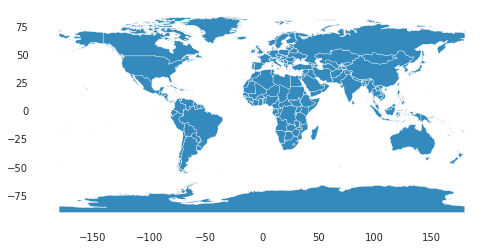

In [4]:
world = gpd.read_file("../../CNTR_RG_10M_2020_4326.shp/CNTR_RG_10M_2020_4326.shp")
world.plot()
plt.show()

In [5]:
world

,CNTR_ID,CNTR_NAME,NAME_ENGL,ISO3_CODE,FID,geometry
0,AD,Andorra,Andorra,AND,AD,"POLYGON ((1.72580 42.50440, 1.60702 42.46145, ..."
1,AE,الإمارات العربية المتحدة,United Arab Emirates,ARE,AE,"MULTIPOLYGON (((56.26584 25.62472, 56.34903 25..."
2,AF,افغانستان-افغانستان,Afghanistan,AFG,AF,"MULTIPOLYGON (((74.88986 37.23409, 74.81968 37..."
3,AG,Antigua and Barbuda,Antigua and Barbuda,ATG,AG,"MULTIPOLYGON (((-61.65852 17.07080, -61.69187 ..."
4,AI,Anguilla,Anguilla,AIA,AI,"POLYGON ((-63.11120 18.18342, -63.07020 18.234..."
...,...,...,...,...,...,...
252,XC,Aksai Chin (Disputed Territory),Aksai Chin,XC,XC,"POLYGON ((78.94793 33.37869, 78.83903 33.43723..."
253,XD,Arunashal Pradesh (Disputed Territory),Arunachal Pradesh,XD,XD,"POLYGON ((97.34711 28.20807, 97.31516 28.07765..."
254,XE,China/India (Disputed Territory),China/India,XE,XE,"MULTIPOLYGON (((79.25368 32.52334, 79.29862 32..."
255,XF,Hala'Ib Triangle (Disputed Territory),Hala'Ib Triangle,XF,XF,"POLYGON ((36.88250 22.00513, 34.08653 22.00251..."


In [6]:
countries_in_eu = """
    A
    Albania
    Andorra
    Armenia
    Austria
    Azerbaijan
    B
    Belarus
    Belgium
    Bosnia and Herzegovina
    Bulgaria
    C
    Croatia
    Cyprus
    Czechia
    D
    Denmark
    E
    Estonia
    F
    Finland
    France
    G
    Georgia
    Germany
    Greece

    H
    Hungary
    I
    Iceland
    Ireland
    Italy
    K
    Kazakhstan
    Kosovo
    L
    Latvia
    Liechtenstein
    Lithuania
    Luxembourg
    M
    Malta
    Moldova
    Monaco
    Montenegro
    N
    Netherlands
    North Macedonia (formerly Macedonia)
    Norway

    P
    Poland
    Portugal
    R
    Romania
    Russia
    S
    San Marino
    Serbia
    Slovakia
    Slovenia
    Spain
    Sweden
    Switzerland
    T
    Turkey
    U
    Ukraine
    United Kingdom (UK)
    V
    Vatican City (Holy See)

"""
countries_in_eu = [a.strip() for a in countries_in_eu.split("\n") if len(a.strip())>1]

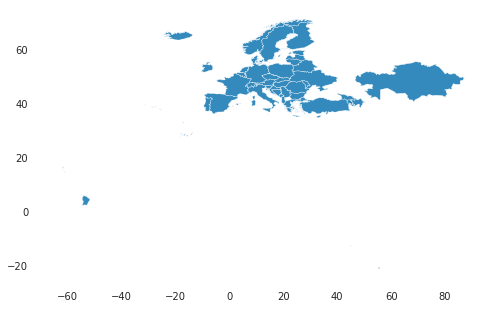

In [7]:
europe = world[world['NAME_ENGL'].apply(lambda x:x in countries_in_eu)]
europe.plot();plt.show()
# ax = europe.plot()
# europe.apply(lambda x: ax.annotate(s=x.NAME_ENGL, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

In [8]:
# Box scale
xmin = -12.
xmax = 50.
ymin = 33.
ymax = 70.

# Coordinates of the box
coords = ((xmin, ymin),(xmin, ymax),(xmax, ymin),(xmax, ymax))
box = shp.geometry.polygon.Polygon(coords)
bounding_box = box.envelope

# Dataframe of box
df = gpd.GeoDataFrame({'geometry': [bounding_box]})

# Intersection
europe_trimmed = gpd.overlay(europe, df)

/home/baran/Work/2019_2020/Internship/Work/env/lib/python3.8/site-packages/geopandas/base.py:48: UserWarning: GeoSeries crs mismatch: epsg:4326 and None
  warn("GeoSeries crs mismatch: {0} and {1}".format(this.crs, other.crs))


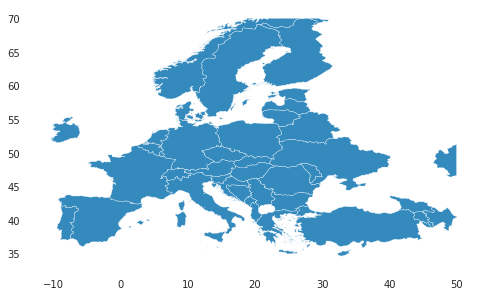

In [9]:
europe_trimmed.plot(); plt.show()

In [11]:
europe_trimmed.to_file("../data/europe_map.shp")